In [1]:
from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
from utils.codificication_mlp import Layer, Cromosome, Fitness

import numpy as np
from time import time

Using TensorFlow backend.


In [2]:
from scipy import stats


class ParameterSensibilation(object):
    
    def __init__(self,chrom, cross_validation=False, iters=5, act=True, drop=True, units=True, layers=True):
        self.cross_val = cross_validation
        self.iters = iters
        self.act = act
        self.drop = drop
        self.units = units
        self.layers = layers
        self.chrom = chrom
        self.levels = 2
        
        
    def start_tests(self):
        print("Testing Baseline")
        self.baseline_data = self.test_single(self.chrom)
        if self.act:
            self.activation_test(self.chrom)
        if self.drop:
            self.dropout_test(self.chrom)
        if self.units:
            self.units_test(self.chrom)
        if self.layers:
            self.layer_test(self.chrom)
        
    def test_single(self, new_chrom):
        fits = np.ones(5)
        print(new_chrom, end='')
        if self.cross_val:
            fits = new_chrom.cross_val(exclude_first=False)
        else:
            fits = [new_chrom.fitness() for i in range(self.iters)]
        print("Fitness: %0.4f (%0.4f)" % (np.mean(fits), np.std(fits)))
        return fits
    
    
    def test_samples(self, new_chroms):
        for new_chrom in new_chroms:
            fits = self.test_single(new_chrom)
            t_value, p_value = stats.ttest_ind(self.baseline_data, fits)
            print("t = %0.4f, p = %0.4f\n" % (t_value, p_value))
        
    
    def activation_test(self, chrom, crossval=True):
        print("\nActivation test:\n")
        new_chroms = []
        all_relu = chrom.self_copy()
        for n in range(len(chrom.layers)):
            new_chrom = chrom.self_copy()
            new_chrom.layers[n].activation = 'relu'
            new_chroms.append(new_chrom)
            all_relu.layers[n].activation = 'relu'
        new_chroms.append(all_relu)
        self.test_samples(new_chroms)


    def dropout_test(self, chrom, crossval=False, delta=False):

        def get_drop(d, i):
            if i < 0:
                return d - d * (2 ** i)
            else:
                return d + (1 - d) * (0.5 ** (i + 1))

        print("\nDropout test\n")
        new_chroms = [chrom.self_copy() for i in range(2 * self.levels)]
        new_chroms = [chrom.self_copy() for i in range(len(chrom.layers))]
        dropout_zero = chrom.self_copy()
        dropout_02 = chrom.self_copy()
        for n in range(len(chrom.layers)):
            dropout_zero.layers[n].dropout = 0
            dropout_02.layers[n].dropout = 0.2
            if delta:
                for i in range(len(new_chroms)):
                    d = new_chroms[i].layers[n].dropout
                    new_chroms[i].layers[n].dropout = get_drop(d, i - self.levels)
            else:
                new_chroms[n].layers[n].dropout = 0.2
        new_chroms.append(dropout_zero)
        new_chroms.append(dropout_02)
        self.test_samples(new_chroms)

    
    def layer_test(self, chrom):
        print("\nLayer test\n")
        new_chroms = [chrom.self_copy()]
        for i in range(len(chrom.layers)):
            original_chrom = new_chroms[-1].self_copy()
            new_layers = original_chrom.layers
            new_layers.pop()
            new_chroms.append(Cromosome(new_layers))
        self.test_samples(new_chroms)


    def units_test(self, chrom, delta=True):
        def get_units(d, i):
            if i < 0:
                return int(d * (1 + i * 0.2))
            else:
                return int(d * (1 + (i + 1) * 0.2))

        print("\nUnits test\n")
        levels = 2
        new_chroms = [chrom.self_copy() for i in range(2 * levels)]
        units_512 = chrom.self_copy()
        for n in range(len(chrom.layers)):
            units_512.layers[n].units = 512
            if delta:
                for i in range(2 * levels):
                    d = new_chroms[i].layers[n].units
                    new_chroms[i].layers[n].units = get_units(d, i - levels)
            else:
                new_chroms[n].layers[n].units = 512
        new_chroms.append(units_512)
        self.test_samples(new_chroms)

In [3]:
l = Layer(512, 'relu', 0.2)
l2 = Layer(512, 'relu', 0.2)
benchm = Cromosome([l, l2])

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# dataset params:
dataset = 'mnist'
classes = []

# genetic algorithm params:
parents_selector_key = 'wheel'
num_parents = 0.3
generations = 40
population = 15
train_time = 10

# Fitness params
epochs = 75
batch_size = 256
maximize_fit = True
verbose = 0
redu_plat = False
early_stop = True

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, batch_size=batch_size, verbose=verbose, reduce_plateau=redu_plat, 
                   epochs=epochs, early_stop=early_stop)
p = ps[parents_selector_key]

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples


Genetic algorithm params:
Number of generations: 40
Population size: 15
num parents: 4
offspring size: 11
1) best fit: 0.985 in batch time: 562.32
5) best fit: 0.985 in batch time: 1545.04
9) best fit: 0.984 in batch time: 2190.94
13) best fit: 0.984 in batch time: 2407.20
17) best fit: 0.985 in batch time: 2158.72
21) best fit: 0.985 in batch time: 2111.95
25) best fit: 0.985 in batch time: 2045.70
29) best fit: 0.984 in batch time: 1471.52
33) best fit: 0.984 in batch time: 1339.57
37) best fit: 0.985 in batch time: 1205.93
41) best fit: 0.985 in batch time: 1095.04
Making statistical validation
Logging data:
[0.9834 0.9845 0.9838 0.9829 0.9824]
[0.9838 0.9835 0.9827 0.9817 0.9802]
Benchmark test score: 0.9824. Winner test score: 0.9834
t = 1.3625457971202881
p = 0.2101434254499876
Best Gen ->  0 - U:532|A:prelu|D:0.292 
1 - U:615|A:relu|D:0.571 

With Fitness (val): 0.984


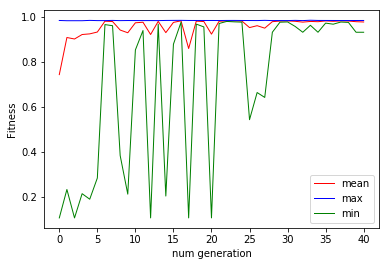

Total elapsed time: 18575.916
Total training time: 18564.175


In [4]:
ti_all = time()
generational = GenerationalGA(num_parents=num_parents, chromosome=benchm, parent_selector=p,
                              generations=generations, num_population=population, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=maximize_fit, training_hours=train_time)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)

In [11]:
import numpy as np
import operator
import matplotlib.pyplot as plt
from scipy import stats

winner_data_val = generational.best_fit_history[winner.__repr__()]
#winner_data   = np.array(winner.cross_val(exclude_first=False, test=True))
#benchmark_data = np.array(generational.chromosome.cross_val(exclude_first=False, test=False))
#winner_data = winner_data_val
winner_data = [winner.fitness() for i in range(5)]
benchmark_data = [generational.chromosome.fitness() for i in range(5)]
print("Logging data:")
print(winner_data)
print(benchmark_data)
print("Benchmark test score: %0.4f. Winner test score: %0.4f" % (np.mean(benchmark_data), np.mean(winner_data)))
t_value, p_value = stats.ttest_ind(winner_data, benchmark_data)
print("t = " + str(t_value))
print("p = " + str(p_value))

Logging data:
[0.9829166666666667, 0.9823333333333333, 0.9843333333333333, 0.9831666666666666, 0.9828333333333333]
[0.98225, 0.9836666666666667, 0.9799166666666667, 0.9813333333333333, 0.98375]
Benchmark test score: 0.9822. Winner test score: 0.9831
t = 1.1695892147664664
p = 0.27583011885542513


In [5]:
ps = ParameterSensibilation(winner)
ps.start_tests()

Testing Baseline
0 - U:532|A:prelu|D:0.292 
1 - U:615|A:relu|D:0.571 
Fitness: 0.9831 (0.0005)

Activation test:

0 - U:532|A:relu|D:0.292 
1 - U:615|A:relu|D:0.571 
Fitness: 0.9834 (0.0003)
t = -0.9117, p = 0.3886

0 - U:532|A:prelu|D:0.292 
1 - U:615|A:relu|D:0.571 
Fitness: 0.9828 (0.0010)
t = 0.5794, p = 0.5783

0 - U:532|A:relu|D:0.292 
1 - U:615|A:relu|D:0.571 
Fitness: 0.9832 (0.0005)
t = -0.3944, p = 0.7036


Dropout test

0 - U:532|A:prelu|D:0.200 
1 - U:615|A:relu|D:0.571 
Fitness: 0.9834 (0.0009)
t = -0.5392, p = 0.6044

0 - U:532|A:prelu|D:0.292 
1 - U:615|A:relu|D:0.200 
Fitness: 0.9826 (0.0009)
t = 0.9382, p = 0.3756

0 - U:532|A:prelu|D:0.000 
1 - U:615|A:relu|D:0.000 
Fitness: 0.9823 (0.0021)
t = 0.7135, p = 0.4958

0 - U:532|A:prelu|D:0.200 
1 - U:615|A:relu|D:0.200 
Fitness: 0.9826 (0.0004)
t = 1.4898, p = 0.1746


Units test

0 - U:319|A:prelu|D:0.292 
1 - U:369|A:relu|D:0.571 
Fitness: 0.9823 (0.0005)
t = 2.3891, p = 0.0439

0 - U:425|A:prelu|D:0.292 
1 - U:492|A:re

In [ ]:
winner = Cromosome([Layer(830, 'prelu',0.654), Layer(782, 'tanh', 0.166), Layer(28, 'elu', 0.062)])
benchm = Cromosome([Layer(512, 'relu', 0.2), Layer(512, 'relu', 0.2)])

In [ ]:
fitness.calc_mean(winner)

In [ ]:
fitness.calc_mean(benchm)